# Multinomial Regression for Predicting Federal Funds Rate Change Based on Meeting

Through this project, I will be exploring how various financial factors play into the Fed's decision to change the Federal Fund Rate to align with their dual mandate of maximum employment and stable prices. 

### Loading Custom Dataset

This dataset contains values from January 17, 1969 to October 31, 2025. Two different data sources were utilized. These data sources are from Romer and Romer's 2004 dataset (1969-2007) and from the Federal Reserve Economic Data, also known as FRED (2009-2025). Manual data entry was done for data points between Februrary 1, 2008 to December 19, 2008 (Data was located through historic Federal Reserve Meeting Minutes). All dates are adjusted to the Friday of the same week to ensure consistency in data across all data sources. Note that this dataset fully considers official Federal Reserve Meetings and the imposed rate changes. Emergency, or unscheduled meetings, may not fully considered because data prior to 2009 on FRED doesn't include the Federal Funds Target Range (a feature implemented on December 16, 2008). 

*Most of the preprocessing is already done through ./dataset/create_dataset.py

In [2701]:
import pandas as pd 

df = pd.read_csv("./dataset/fred_romer_change_bps_dataset_1969_2025.csv")

print(df.shape)
df.info()
df.describe()

(510, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date                           510 non-null    object 
 1   adjusted_change_bps            510 non-null    int64  
 2   cpi_yoy                        510 non-null    float64
 3   cpi_12w_change                 510 non-null    float64
 4   inflation                      510 non-null    float64
 5   gdp_yoy                        510 non-null    float64
 6   gdp_26w_change                 510 non-null    float64
 7   unemployment_rate              510 non-null    float64
 8   unemployment_rate_12w_change   510 non-null    float64
 9   consumer_sentiment             510 non-null    float64
 10  consumer_sentiment_12w_change  510 non-null    float64
 11  ffr_mid                        510 non-null    float64
 12  ffr_change_12w                 510 non-n

,adjusted_change_bps,cpi_yoy,cpi_12w_change,inflation,gdp_yoy,gdp_26w_change,unemployment_rate,unemployment_rate_12w_change,consumer_sentiment,consumer_sentiment_12w_change,ffr_mid,ffr_change_12w,num_hikes_12w,num_cuts_12w,weeks_since_last_hike,weeks_since_last_cut,recession
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.588235,4.256619,0.017085,3.624512,0.129219,-0.065067,6.009020,0.034510,83.077059,-0.300588,5.136392,-0.088235,1.131373,0.949020,0.105882,0.080392,0.139216
std,15.182164,2.982732,0.849692,2.238125,0.611866,0.785353,1.741777,0.833098,12.901361,6.445956,3.796739,110.389634,1.119744,1.086327,0.307989,0.272166,0.346511
min,-50.000000,-1.483836,-4.975548,0.650944,-7.876784,-7.876784,3.400000,-3.200000,50.000000,-28.700000,0.125000,-858.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.282394,-0.395701,1.794161,0.000000,0.000000,4.700000,-0.200000,73.750000,-4.375000,1.875000,-25.750000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3.340434,-0.017278,2.986033,0.000000,0.000000,5.700000,0.000000,84.600000,-0.100000,5.215000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,5.548878,0.437254,4.760631,0.000000,0.000000,7.200000,0.100000,92.800000,3.200000,7.287500,35.000000,2.000000,2.000000,0.000000,0.000000,0.000000
max,50.000000,14.592275,4.192066,10.219987,3.864773,7.876784,14.800000,11.200000,111.300000,20.900000,19.040000,803.000000,3.000000,4.000000,1.000000,1.000000,1.000000


### Separating Labels and Features

The dataset is separated into a 80/20 split. Since it is sequential data, the split is done by spliting the first 80% of the dataset, and the last 20% of the dataset without mixing the time frames.  

In [2702]:
from sklearn.model_selection import train_test_split

label = "adjusted_change_bps"

df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

train_split = int(len(df) * 0.80)

train_df = df.iloc[:train_split]
test_df = df.iloc[train_split:]

train_y_5_class = train_df[label]
train_X = train_df.drop(columns=["date", label])

test_y_5_class = test_df[label]
test_X = test_df.drop(columns=["date", label])

print(len(train_y_5_class), len(train_X))
print(len(test_y_5_class), len(test_X))

408 408
102 102


### Feature Engineering
This section is where I am modifing each feature to create strongest model possible. 

The list below represents the training features that the default model uses.


training_features = [
    "cpi_yoy", 
    "cpi_12w_change", 
    "inflation",
    "gdp_yoy", 
    "gdp_26w_change",
    "unemployment_rate", 
    "unemployment_rate_12w_change",
    "consumer_sentiment", 
    "consumer_sentiment_12w_change",
    "ffr_mid", 
    "ffr_change_12w",
    "num_hikes_12w", 
    "num_cuts_12w",
    "weeks_since_last_hike", 
    "weeks_since_last_cut",
    "recession"
]

In [2703]:

# minimal work needs to be done as both models yield high accuracy
# features have also already been modified during dataset creation 
training_features = [
    #"cpi_yoy", 
    "cpi_12w_change", 
    "inflation",
    "gdp_yoy", 
    "gdp_26w_change",
    "unemployment_rate", 
    "unemployment_rate_12w_change",
    "consumer_sentiment", 
    "consumer_sentiment_12w_change",
    #"ffr_mid", 
    "ffr_change_12w",
    "num_hikes_12w", 
    "num_cuts_12w",
    "weeks_since_last_hike", 
    "weeks_since_last_cut",
    "recession"
]

train_X = train_X[training_features].dropna()
test_X = test_X[training_features].dropna()

The default model has a 5 class input, but due to a lack of data for the test set (inbalanced data), I will also have a model that just determines if it is a rate hike, hold, or cut. 

default input is [-50, -25, 0, 25, 50] 

simplified three class input is [cut, hold, hike] -> [-1, 0, 1]

In [2704]:
import numpy as np

train_y_3_class = np.sign(train_y_5_class).astype(int)
test_y_3_class = np.sign(test_y_5_class).astype(int)

print(train_y_3_class.value_counts())
print(test_y_3_class.value_counts())

adjusted_change_bps
 0    340
 1     34
-1     34
Name: count, dtype: int64
adjusted_change_bps
 0    72
 1    20
-1    10
Name: count, dtype: int64


### Normalizing Features 

Features here are normalized to ensure that each feature is contributing equally to the model result. 

In [2705]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

train_X = scaler.fit_transform(train_X)
test_X = scaler.fit_transform(test_X)

### Training and Saving Model

Train 5 Class Model 

In [2706]:
import pickle 
from sklearn.linear_model import LogisticRegression

model_5 = LogisticRegression(C= 0.001, class_weight="balanced", penalty="l2", solver="lbfgs", multi_class="multinomial", max_iter=1000)

model_5.fit(train_X, train_y_5_class)

model_5_class = "model_5_class.pkl"

with open(model_5_class, 'wb') as f: 
    pickle.dump(model_5, f)

c:\Users\jchen\Desktop\cs5805\ML_Federal_Rates_Project\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Train 3 Class Model

In [2707]:
model_3 = LogisticRegression(class_weight="balanced", solver="lbfgs", multi_class="multinomial", max_iter=1000)

model_3.fit(train_X, train_y_3_class)

model_3_class = "model_3_class.pkl"

with open(model_3_class, 'wb') as f: 
    pickle.dump(model_3, f)

c:\Users\jchen\Desktop\cs5805\ML_Federal_Rates_Project\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


### Testing Model on Test Set

The evaluation metrics I am using are accuracy, precision, recall, f1 score, and confusion matrices. The confusion matrices determine the proportion of predictions that correctly identified the right label. I am also including the coefficient matrix for both models to determine the features that have the most impact on each of the label classes. 

5 Class Model Results

In [2708]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

with open(model_5_class, 'rb') as f: 
    model_5_v1 = pickle.load(f)

pred_train_y_5_class = model_5_v1.predict(train_X)
pred_y_5_class = model_5_v1.predict(test_X)

print("Train Accuracy:", accuracy_score(train_y_5_class, pred_train_y_5_class))
print("Test Accuracy:", accuracy_score(test_y_5_class, pred_y_5_class))
print("Precision:", precision_score(test_y_5_class, pred_y_5_class, average="macro"))
print("Recall:", recall_score(test_y_5_class, pred_y_5_class, average="macro"))
print("F1 Score:", f1_score(test_y_5_class, pred_y_5_class, average="macro"))

print()

print(classification_report(test_y_5_class, pred_y_5_class))

print("Coefficient Matrix")
coefficient_matrix_5_class = pd.DataFrame(
    model_5_v1.coef_,
    columns=training_features,
    index=["-50 bps", "-25 bps", "0 bps", "25 bps", "50 bps"]
)
print(coefficient_matrix_5_class.T.round(3))


Train Accuracy: 0.9166666666666666
Test Accuracy: 0.8921568627450981
Precision: 0.7329004329004329
Recall: 0.7964285714285715
F1 Score: 0.7272890444158878

              precision    recall  f1-score   support

         -50       0.29      0.67      0.40         3
         -25       0.83      0.71      0.77         7
           0       1.00      0.96      0.98        72
          25       1.00      0.64      0.78        14
          50       0.55      1.00      0.71         6

    accuracy                           0.89       102
   macro avg       0.73      0.80      0.73       102
weighted avg       0.94      0.89      0.90       102

Coefficient Matrix
                               -50 bps  -25 bps  0 bps  25 bps  50 bps
cpi_12w_change                  -0.046    0.013  0.022   0.020  -0.010
inflation                        0.010   -0.028  0.007  -0.025   0.036
gdp_yoy                         -0.012    0.022 -0.018   0.020  -0.011
gdp_26w_change                  -0.006    0.029 -0.0

5 Class Model Confusion Matrix

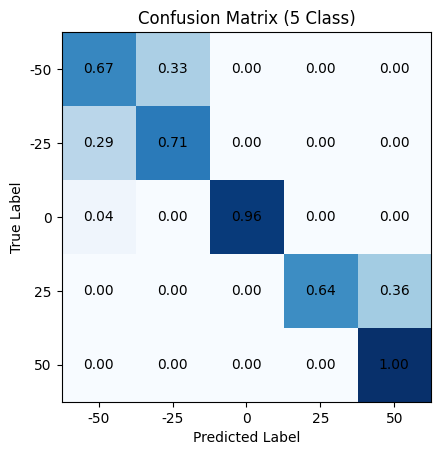

In [2709]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

matrix_5_class = confusion_matrix(test_y_5_class, pred_y_5_class)

matrix_5_class = matrix_5_class.astype(float) / matrix_5_class.sum(axis=1, keepdims=True)

plt.figure()
plt.imshow(matrix_5_class , cmap="Blues")
plt.title("Confusion Matrix (5 Class)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

class_labels_5 = [-50, -25, 0, 25, 50]
plt.xticks(np.arange(len(class_labels_5)), class_labels_5)
plt.yticks(np.arange(len(class_labels_5)), class_labels_5)


# calculating prob
for i in range(matrix_5_class.shape[0]):
    for j in range(matrix_5_class.shape[1]):
        plt.text(j, i, f"{matrix_5_class[i, j]:.2f}", ha="center", va="center")

plt.show()

3 Class Model Results

In [2710]:
with open(model_3_class, 'rb') as f: 
    model_3_v1 = pickle.load(f)

pred_train_y_3_class = model_3_v1.predict(train_X)
pred_y_3_class = model_3_v1.predict(test_X)

print("Train Accuracy:", accuracy_score(train_y_3_class, pred_train_y_3_class))
print("Test Accuracy:", accuracy_score(test_y_3_class, pred_y_3_class))
print("Precision:", precision_score(test_y_3_class, pred_y_3_class, average="macro"))
print("Recall:", recall_score(test_y_3_class, pred_y_3_class, average="macro"))
print("F1 Score:", f1_score(test_y_3_class, pred_y_3_class, average="macro"))
print()
print("Classification Results")
print(classification_report(test_y_3_class, pred_y_3_class))
print()

print("Coefficient Matrix")
coefficient_matrix_3_class = pd.DataFrame(
    model_3_v1.coef_,
    columns=training_features,
    index=["cut (-1)", "hold (0)", "hike (+1)"]
)
print(coefficient_matrix_3_class.T.round(3))


Train Accuracy: 1.0
Test Accuracy: 0.9901960784313726
Precision: 0.9696969696969697
Recall: 0.9953703703703703
F1 Score: 0.9817959817959818

Classification Results
              precision    recall  f1-score   support

          -1       0.91      1.00      0.95        10
           0       1.00      0.99      0.99        72
           1       1.00      1.00      1.00        20

    accuracy                           0.99       102
   macro avg       0.97      1.00      0.98       102
weighted avg       0.99      0.99      0.99       102


Coefficient Matrix
                               cut (-1)  hold (0)  hike (+1)
cpi_12w_change                   -0.507     0.481      0.026
inflation                        -0.485     0.442      0.044
gdp_yoy                          -0.008    -0.046      0.055
gdp_26w_change                    0.196    -0.125     -0.072
unemployment_rate                -0.333     0.277      0.056
unemployment_rate_12w_change     -0.691     0.631      0.060
consumer

3 Class Model Confusion Matrix

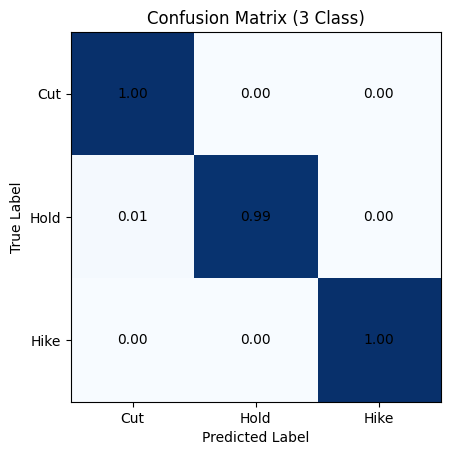

In [2711]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

matrix_3_class = confusion_matrix(test_y_3_class, pred_y_3_class)

matrix_3_class = matrix_3_class.astype(float) / matrix_3_class.sum(axis=1, keepdims=True)

plt.figure()
plt.imshow(matrix_3_class , cmap="Blues")
plt.title("Confusion Matrix (3 Class)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

class_labels_3 = ["Cut", "Hold", "Hike"]
plt.xticks(np.arange(len(class_labels_3)), class_labels_3)
plt.yticks(np.arange(len(class_labels_3)), class_labels_3)


# calculating prob
for i in range(matrix_3_class.shape[0]):
    for j in range(matrix_3_class.shape[1]):
        plt.text(j, i, f"{matrix_3_class[i, j]:.2f}", ha="center", va="center")

plt.show()